In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from calpycles.pycles_sample import SampleDYCOMS_RF01
from calpycles.pycles_ensemble import PyCLESensemble
from calpycles.parameters import ParametersDYCOMS_RF01 
PARAMS = ParametersDYCOMS_RF01()

import numpy as np
import os

# location
this_path = os.path.abspath("")
data_folder = os.path.join(this_path,"data/")

Using custom matplotlib style from 'mplstyle' file


In [25]:
n_ens = 10
name = f"DYCOMS_RF01_N{n_ens}_variability"
model_name = "WENO_FULLRES"

ens = PyCLESensemble(
    name=name,
    n_samples=n_ens,
    path=os.path.join(data_folder, model_name, name),
    verbose=True,
    test=False,
    case="DYCOMS_RF01",
)

# # set parameter samples
# ens.param_ens.set(np.stack([PARAMS.defaults]*N_rep, axis=0), constrained=True)

## cant plot degenerate ensemble
# ens.param_ens.plot()

# # initialize samples from these parameters
# namelist_settings = make_namelist_settings(model_name)

# ens.init_samples(  
#     # namelist_settings=namelist_settings
# )


# manually initialize the samples to have the different seeds
# and to get exact value of cs=0 avoiding evaluating the transform at the margin 
ens._samples = [] # [sample with custom namelist seed]
for i in range(n_ens):
    # initialize sample with this seed
    sample = SampleDYCOMS_RF01(
        name = str(i),
        parameters = None,  # nature
        parent_path=ens.path,
        namelist_settings={
            "initialization": {
                "random_seed_factor": i+1,
            },
            "mpi": {
                "nprocx": 16,
                "nprocy": 1,
                "nprocz": 1
            },
        },
    )
    # sample.parameters.set_from_np(PARAMS.defaults)
    sample.write_namelist()
    ens._samples.append(sample)

# assemble parameter ensemble
param_samples = np.array([
    ens.samples[0].parameters.parameters for i in range(n_ens)
])
ens.param_ens.set(param_samples, constrained="True")
ens.param_ens.save()

Using default parameter properties in parameter ensemble init.
Using specified parameter ranges to assemble dist_kwargs.
Saved GaussRV mean and var to /cluster/work/climate/dgrund/experiments/clean_paper_experiments/data/WENO_FULLRES/DYCOMS_RF01_N10_variability/dist_parameters_mean.npy; _covar.npy
Saved parameter samples (.npy, .nc, .txt) to  /cluster/work/climate/dgrund/experiments/clean_paper_experiments/data/WENO_FULLRES/DYCOMS_RF01_N10_variability
Saved parameter samples (.npy, .nc, .txt) to  /cluster/work/climate/dgrund/experiments/clean_paper_experiments/data/WENO_FULLRES/DYCOMS_RF01_N10_variability


In [26]:
# the param ens saves the cs>0 values corrected from the transform
ens.param_ens.samples[:,-2]

array([-5.52084024, -5.52084024, -5.52084024, -5.52084024, -5.52084024,
       -5.52084024, -5.52084024, -5.52084024, -5.52084024, -5.52084024])

In [27]:
# but the samples themselves have exact cs=0
ens.samples[0].namelist.namelist["sgs"]

{'Smagorinsky': {'cs': 0.0, 'prt': 0.3333333333333333},
 'scheme': 'Smagorinsky'}

In [28]:
ens.run(
    submit_job=True,
    do_wait_and_clean=False,
)

Submitting ensemble from slurm script stored in  /cluster/work/climate/dgrund/experiments/clean_paper_experiments/data/WENO_FULLRES/DYCOMS_RF01_N10_variability/slurm_script.sh
Submitted batch job 53274496


In [6]:
# after samples finished, prepare evaluation
from data_loaders import load_ens_posterior

from calpycles.pycles_ensemble import move_slurm_files

n_ens = 10
name = f"DYCOMS_RF01_N{n_ens}_variability"
model_name = "WENO_FULLRES"

ens = PyCLESensemble(
    name=name,
    n_samples=n_ens,
    path=os.path.join(data_folder, model_name, name),
    verbose=True,
    case="DYCOMS_RF01",
    test=False,
)

ens.load()

# tidy up the ensemble path from slurm stuff
move_slurm_files(ens.path)

# clean up each sample
for sample in ens.samples:
    sample.clean_files(
        # delete_fields: bool = True,
        # select_stats: bool = True,
        # delete_cond_stats: bool = True,
        # delete_second_infile: bool = True,
        # remove_uuid_from_outdir: bool = True,
    )

# prepare evaluation
ens.obs_ens.observe()
ens.obs_ens.compute_stats()
# ens.plot()

Using default parameter properties in parameter ensemble init.
Using specified parameter ranges to assemble dist_kwargs.
Loaded parameter samples from  /cluster/work/climate/dgrund/experiments/clean_paper_experiments/data/WENO_FULLRES/DYCOMS_RF01_N10_variability/samples_parameters_unconstrained.npy
Loading 10 samples for ensemble DYCOMS_RF01_N10_variability...
... done loading samples for ensemble DYCOMS_RF01_N10_variability.
Cleaning sample files of 0...
Cleaning sample files of 1...
Cleaning sample files of 2...
Cleaning sample files of 3...
Cleaning sample files of 4...
Cleaning sample files of 5...
Cleaning sample files of 6...
Cleaning sample files of 7...
Cleaning sample files of 8...
Cleaning sample files of 9...
Observing observation ensemble DYCOMS_RF01_N10_variability...
Creating observation ensemble DYCOMS_RF01_N10_variability...
Reading full profiles and timeseries for ObEnsembleDYCOMS_RF01...
	[create_mfdataset_with_nans()] Found 10 files.


/cluster/work/climate/dgrund/git/dana-grund/CalPyCLES/environment/.venv/calpycles/lib/python3.9/site-packages/xarray/core/concat.py:544: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  common_dims = tuple(pd.unique([d for v in vars for d in v.dims]))


	[create_mfdataset_with_nans()] Found 10 files.


/cluster/work/climate/dgrund/git/dana-grund/CalPyCLES/environment/.venv/calpycles/lib/python3.9/site-packages/xarray/core/concat.py:544: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  common_dims = tuple(pd.unique([d for v in vars for d in v.dims]))


Saved full obs ensemble 'DYCOMS_RF01_N10_variability' to
/cluster/work/climate/dgrund/experiments/clean_paper_experiments/data/WENO_FULLRES/DYCOMS_RF01_N10_variability/samples_observations_full_profiles.nc / _timeseries.nc.
Loaded observation DYCOMS_RF01_N10_variability from ('/cluster/work/climate/dgrund/experiments/clean_paper_experiments/data/WENO_FULLRES/DYCOMS_RF01_N10_variability/samples_observations_full_profiles.nc', '/cluster/work/climate/dgrund/experiments/clean_paper_experiments/data/WENO_FULLRES/DYCOMS_RF01_N10_variability/samples_observations_full_timeseries.nc').
Computing observation ensemble profile stats...
Reading...
Computing...
Saving /cluster/work/climate/dgrund/experiments/clean_paper_experiments/data/WENO_FULLRES/DYCOMS_RF01_N10_variability/ensemble_stats/Nens10_profiles_average_time_mean.nc...
Saving /cluster/work/climate/dgrund/experiments/clean_paper_experiments/data/WENO_FULLRES/DYCOMS_RF01_N10_variability/ensemble_stats/Nens10_profiles_average_time_median.nc

Using default parameter properties in parameter ensemble init.
Using specified parameter ranges to assemble dist_kwargs.
Loaded parameter samples from  /cluster/work/climate/dgrund/experiments/clean_paper_experiments/data/WENO_FULLRES/DYCOMS_RF01_N10_variability/samples_parameters_unconstrained.npy
Loading 10 samples for ensemble DYCOMS_RF01_N10_variability...
... done loading samples for ensemble DYCOMS_RF01_N10_variability.
Loaded observation DYCOMS_RF01_N10_variability from /cluster/work/climate/dgrund/experiments/clean_paper_experiments/data/WENO_FULLRES/DYCOMS_RF01_N10_variability/samples_observations.nc.
Reading full profiles and timeseries for ObEnsembleDYCOMS_RF01...
	[create_mfdataset_with_nans()] Found 1 files.


/cluster/work/climate/dgrund/git/dana-grund/CalPyCLES/environment/.venv/calpycles/lib/python3.9/site-packages/xarray/core/concat.py:544: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  common_dims = tuple(pd.unique([d for v in vars for d in v.dims]))


	[create_mfdataset_with_nans()] Found 1 files.


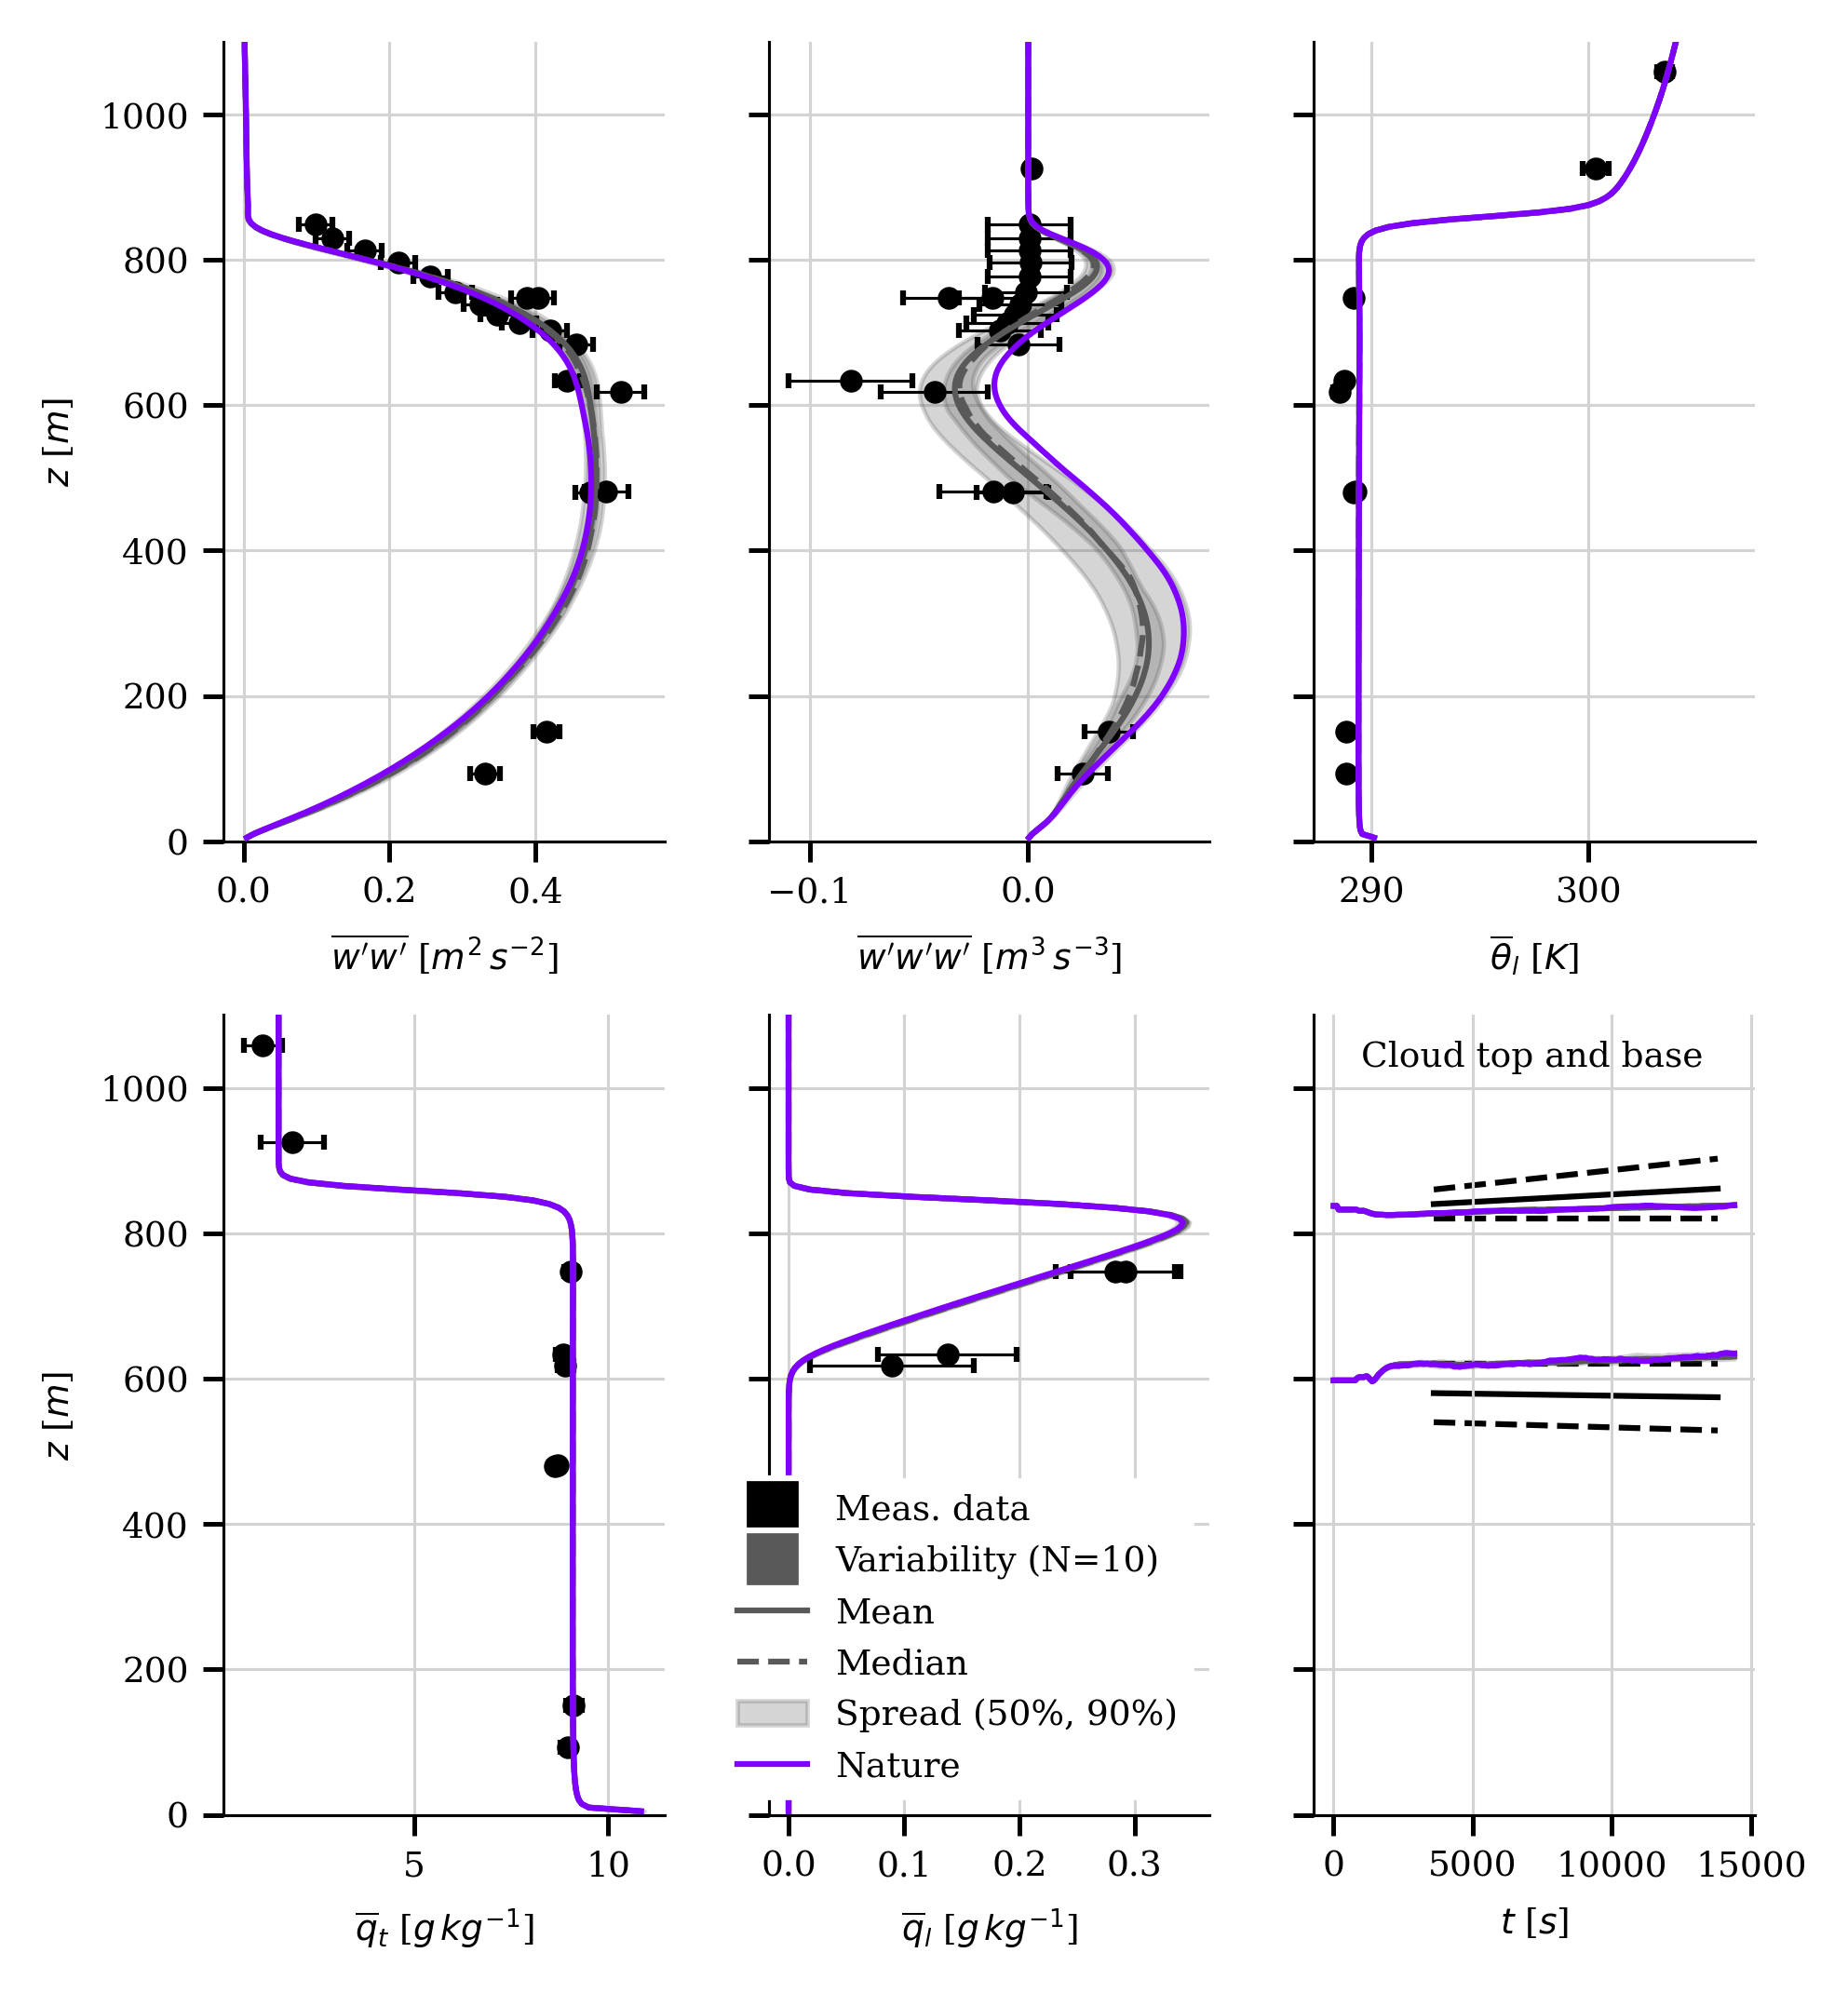

Saved figure  figs/WENO_FULLRES/variability/fig-obs_prior_variability


In [7]:
from data_loaders import load_ens
from data_loaders import load_ens_posterior
from data_loaders import load_nature
from calpycles.plotting.ens_obs import plot_ens_obs
from calpycles.DYCOMS_RF01.measurements import MeasurementsDYCOMS_RF01
meas = MeasurementsDYCOMS_RF01()

n_ens = 10
name = f"DYCOMS_RF01_N{n_ens}_variability"
model_name = "WENO_FULLRES"

ens = PyCLESensemble(
    name=name,
    n_samples=n_ens,
    path=os.path.join(data_folder, model_name, name),
    verbose=True,
    case="DYCOMS_RF01",
    test=False,
)

ens.load()

nature = load_nature(model_name)

plot_ens_obs(
    ensembles=[ens],
    ens_labels=["Variability (N=10)"],
    data=meas,
    nature=nature,
    nature_name="Nature",
    save_file=f"figs/{model_name}/variability/fig-obs_prior_variability",
    cloud_height_type="mean",
)